# Dataset Pipeline
https://www.tensorflow.org/guide/datasets#training_workflows
- assemble pipeline for the simle model
- could I use keras here?
- could I use tensorflow board here?

In [38]:
import os
import cifar10
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print('tf.__version__:', tf.__version__)
print('keras.__version__:', keras.__version__)

tf.__version__: 1.9.0-rc0
keras.__version__: 2.1.6-tf


## TF.Dataset for CIFAR-10
### Features
- load data from site
- convert internal CIFAR-10 format to the useful for tf.data.dataset (TFRecord)

In [3]:
dataset_path = os.path.join(os.getcwd(), 'cifar10-data')

In [4]:
!python ./cifar10/generate_cifar10_tfrecords.py --data-dir="$dataset_path" --log-level=DEBUG

INFO:__main__:Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract to /opt/notebooks/keras-experiments/cifar10-data.
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/train.tfrecords
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/validation.tfrecords
INFO:__main__:Generating /opt/notebooks/keras-experiments/cifar10-data/eval.tfrecords
INFO:__main__:Done!


Show downloaded files

In [5]:
!ls -la "$dataset_path"

total 373952
drwxr-xr-x  7 root root       224 Aug 19 13:58 .
drwxr-xr-x 15 root root       480 Aug 19 13:58 ..
drwxr-xr-x 10 2156 1103       320 Jun  4  2009 cifar-10-batches-py
-rw-r--r--  1 root root 170498071 Aug 19 13:31 cifar-10-python.tar.gz
-rw-r--r--  1 root root  31260000 Aug 19 13:58 eval.tfrecords
-rw-r--r--  1 root root 125040000 Aug 19 13:58 train.tfrecords
-rw-r--r--  1 root root  31260000 Aug 19 13:58 validation.tfrecords


### Show dataset images of a single batch

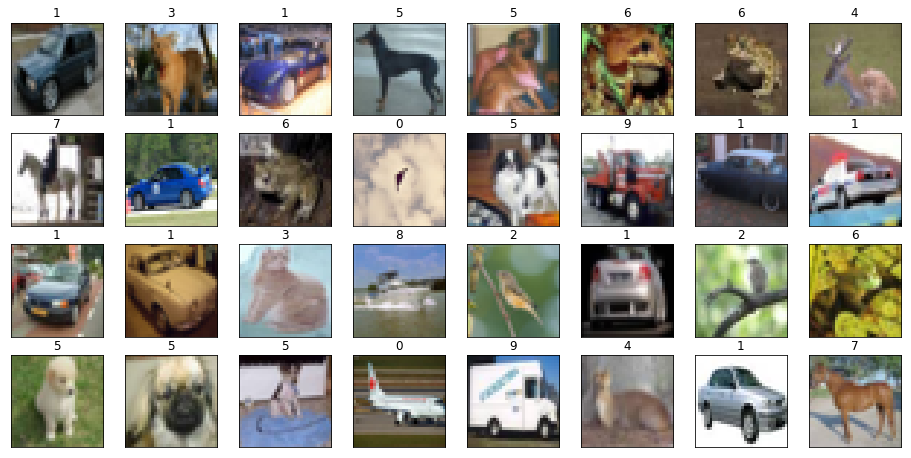

In [74]:
dataset = cifar10.dataset.TFDataSet(dataset_path).make_dataset()
iterator = cifar10.make_iterator(dataset)

with tf.Session() as sess:
    next_element = iterator.get_next()
    sess.run(tf.global_variables_initializer())
    examples = sess.run(next_element)

    grid_width = 16
    rows = 9
    items_in_a_row = 8
    plt.figure(figsize=(grid_width, grid_width / items_in_a_row * rows))
    for idx, (image, label) in enumerate(zip(examples[0], examples[1])):
        plt.subplot(rows, items_in_a_row, idx + 1)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        # for some reasons matplotlib convert color data is inverted
        plt.imshow(image/256., interpolation='nearest')
    plt.show()

### Use Pre-made estimators
#### Train model

In [105]:
def train_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='train')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    ds = ds.repeat()
    ds = ds.shuffle(1000)    
    return ds

my_feature_columns = [tf.feature_column.numeric_column('image', shape=[3, 32, 32])]

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[256, 32],
    optimizer=tf.train.AdamOptimizer(1e-4),
    dropout=0.1,
    # The model must choose between 3 classes.
    n_classes=10,
    model_dir='checkpoints/dnn-256-32')

classifier.train(input_fn=train_input_fn, steps=1000)

#### Checkpoints are here

In [103]:
print('classifier.model_dir', classifier.model_dir)
!ls "$classifier.model_dir"

checkpoint
events.out.tfevents.1534933926.b89c062a0226
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


#### Estimate model

In [104]:
def validation_input_fn():
    dataset_builder = cifar10.dataset.TFDataSet(dataset_path, subset='validation')
    ds = dataset_builder.make_dataset()
    ds = ds.batch(16)
    
# we don't need it on validation
# 
#     ds = ds.repeat()
#     ds = ds.shuffle(1000)
    return ds

accuracy_score = classifier.evaluate(input_fn=validation_input_fn)['accuracy']
print(accuracy_score)

0.0977


### TODO: Create Estimator based on TF Model

### TODO: Create Estimator based on Keras Model

- create dataset to consume TFRecord (lazy - without loading all at once to memory) - memory efficient strategy
- data augmentation (flipping images)
- TODO: cross validation

## Use CIFAR-10 Dataset to train simple model
- TODO: try to use keras
- TODO: try to compare with and without TF.Dataset
- TODO: connect to tf.board